In [246]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import data_reader
import matplotlib.patches as mpatches
import os
import matplotlib.lines as mlines
import random

%matplotlib inline

In [247]:
dr = data_reader.DataReader()
figure_path = 'C:/Users/azgonnikov/Dropbox/Research/Journal papers/2019 Changes-of-mind/v 0.2/figures'
data_path = 'C:/Users/azgonnikov/Google Drive/data/CoM_fixed_duration/processed'
model_output_csv_path = '../output/csv/'

choices, dynamics = dr.get_data(path=data_path, stim_viewing=False, rename_vars=True)

In [248]:
choices.index.get_level_values('block_no').max()

11

# Figure 1

In [232]:
def get_screen_params():
    return {'x_lim':[-960-10, 960+10],
            'y_lim':[0-10, 1080+10],
            'left_resp_area_center':[-(960-150), (1080-170)],
            'right_resp_area_center':[(960-150), (1080-170)],
            'resp_area_radius':90}
    
def plot_response_areas(trajectory, ax):
    p = get_screen_params()
    
    y_error_l = (p['left_resp_area_center'][0]-p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    y_error_u = (p['left_resp_area_center'][0]+p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    
    ax.fill_between(trajectory.timestamp, y_error_l, y_error_u, alpha=0.1, facecolor='red', edgecolor=None)
    
    y_correct_l = (p['right_resp_area_center'][0]-p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    y_correct_u = (p['right_resp_area_center'][0]+p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
        
    ax.fill_between(trajectory.timestamp, y_correct_l, y_correct_u, alpha=0.1, facecolor='green', edgecolor=None)

def plot_traj_xy(ax, trajectory):
    p = get_screen_params()
    ax.set_aspect('equal')
    ax.set_xlim(p['x_lim'])
    ax.set_ylim(p['y_lim'])
    left_resp_area = plt.Circle(p['left_resp_area_center'], p['resp_area_radius'], 
                                alpha=0.3, facecolor='red', edgecolor='white')
    right_resp_area = plt.Circle(p['right_resp_area_center'], p['resp_area_radius'], 
                                 alpha=0.3, facecolor='green', edgecolor='white')
    ax.add_artist(left_resp_area)
    ax.add_artist(right_resp_area)
    
    ax.plot(trajectory.mouse_x[::4], trajectory.mouse_y[::4], #marker='o', markersize=7, 
            alpha=0.6, color='grey', lw=5)
    ax.set_xticks((-1000, -500, 0, 500, 1000))
    ax.set_yticks((0, 500, 1000))
    ax.tick_params(axis='both', labelsize=18)

def plot_trajectories_xy(exp_non_com_traj, exp_com_traj):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey='row')

    plot_traj_xy(ax1, exp_non_com_traj)
    plot_traj_xy(ax2, exp_com_traj)

    label_font_size = 24

    ax1.set_xlabel('x position (px)', fontsize=label_font_size)
    ax1.set_ylabel('y position (px)', fontsize=label_font_size)
    ax1.set_title('non-CoM')

    ax2.set_xlabel('x position (px)', fontsize=label_font_size)   
    ax2.set_title('CoM')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

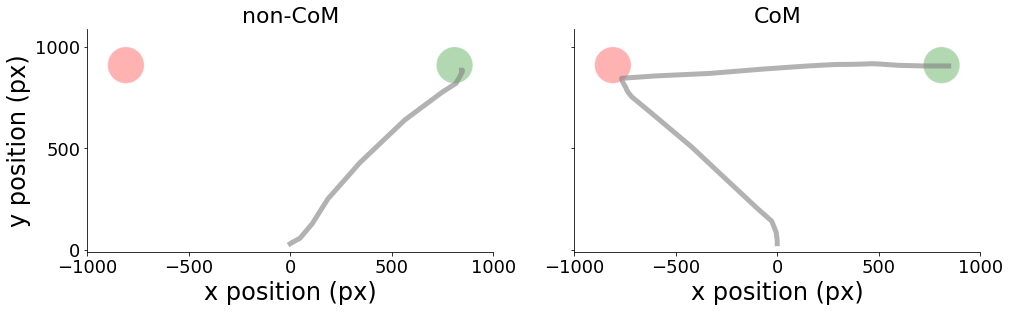

In [233]:
plot_trajectories_xy(exp_non_com_traj=dynamics.loc[(391, 2, 10, 39)], exp_com_traj=dynamics.loc[(391, 3, 6, 17)])
plt.savefig(os.path.join(figure_path, 'xy_trajectories.png') , bbox_inches='tight')

# Figure 2

In [250]:
def get_psf_ci(c, n_threshold=0):
    # c is a choices dataframe
    # psf is a psychometric function
    # ci is a dataframe with confidence intervals for probability per coherence
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.type==t)]) / 
                   len(c[(c.coherence==coherence) & (c.type==t)]) 
               if len(c[(c.coherence==coherence) & (c.type==t)]) > n_threshold else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for t in np.sort(c.type.unique())])
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.type.unique())], 
                                                         names=['coherence', 'type']))
    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.type.unique())], 
                                                         names=['coherence', 'type']))

    n = [len(c[(c.coherence==coherence) & (c.type==t)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for t in np.sort(c.type.unique())]

    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)

    return p_correct.reset_index(), ci.reset_index()

def plot_psychometric_function(ax, choices, n_threshold=10):
    p_correct, ci = get_psf_ci(choices[choices.coherence>0])
    sns.pointplot(data=p_correct, x='coherence', y='p_correct', hue='type', styles=['o', 'v'], 
                  scale=1, join=True, palette=['grey', 'black'], linestyles=['-', '-'], ax=ax)
    ax.vlines(x=range(0,5), ymin=ci[ci.type=='non-CoM'].ci_l, ymax=ci[ci.type=='non-CoM'].ci_r, 
                 color='black', zorder=10)    
    ax.vlines(x=range(0,5), ymin=ci[ci.type=='CoM'].ci_l, ymax=ci[ci.type=='CoM'].ci_r, 
                 color='grey', zorder=10)
    
    ax.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.4, 1.0, 7)))    
    ax.get_legend().set_title('')    
    ax.set_xlabel('')
    ax.set_ylabel('p(correct)')

def get_ci_p_com(c, correct_col='is_correct', n_threshold=10):
    p_com = np.array([len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)])>n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c[correct_col].unique())])
    n = [len(c[(c.coherence==coherence) & (c[correct_col]==is_correct)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_correct in np.sort(c[correct_col].unique())]

    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c[correct_col].unique())], 
                                                         names=['coherence', correct_col]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def get_ci_p_com_total(c, n_threshold=10):
    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    
    ci = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])  
    
    p_com = ci.p_com
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def plot_p_com(ax, c):
    n_threshold = 0
    correct_col='is_correct'
    
    p_com_total = pd.DataFrame([(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
                               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
                               for coherence in np.sort(c.coherence.unique())], columns=['p_com', 'coherence'])
    
    sns.pointplot(data=p_com_total, x='coherence', y='p_com', scale=1.0, color='grey', join=True, ax=ax)
    
    p_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
             if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) > n_threshold) else 0  
             for coherence in np.sort(c.coherence.unique()) 
             for is_correct in np.sort(c[correct_col].unique())]
    
    p_com = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', correct_col]))
    # no correct/error labels for zero coherence
    p_com.loc[0] = np.NaN

    sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue=correct_col,
                       palette=['k', 'k'], linestyles=['--', '-'], scale=1.0, ax=ax, join = True)
    
    ci_total = get_ci_p_com_total(c, n_threshold=n_threshold)
    ax.vlines(x=range(0,6), ymin=ci_total.ci_l, ymax=ci_total.ci_r, color='grey', zorder=10)
    
    ci = get_ci_p_com(c, correct_col, n_threshold=n_threshold)
    ax.vlines(x=[val for pair in zip(range(1,6), range(1,6)) for val in pair], 
              ymin=ci[ci.coherence>0].ci_l, ymax=ci[ci.coherence>0].ci_r, color='black', zorder=10)

    ax.set_ylim(-0.005, 0.06)
    ax.legend(handles=ax.lines[::len(choices.coherence.unique())+1],labels=['Total','Error','Correct'], frameon=True)
    ax.set_xlabel('')
    ax.set_ylabel('p(CoM)')
    sns.despine(ax=ax, trim=True, offset=10)

def plot_rt(ax, choices):
#     choices = choices.drop(choices[(choices.coherence == 0.512) & (choices.is_com == True)].index)
    var = 'RT (z)'
    sns.pointplot(data=choices[(choices.coherence > 0) & (~choices.is_correct) & (choices.is_com == True)],
                       x='coherence', y=var, linestyles=['--'], color='grey', markers=['x'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == True)],
                       x='coherence', y=var, linestyles=['-'], color='grey', markers=['o'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.coherence < 0.512) & 
                               (~choices.is_correct) & (choices.is_com == False)],
                       x='coherence', y=var, linestyles=['--'], color='black', markers=['x'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)

    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == False)],
                       x='coherence', y=var, linestyles=['-'], color='black', markers=['o'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)
    
    ax.legend(handles=ax.lines[::6], labels=['Error CoM', 'Correct CoM', 'Error non-CoM', 'Correct non-CoM'], 
                 fontsize=16, frameon=True)
    ax.set(ylim=(-2.0, 2.0))
    ax.set_ylabel('Response time (z)')

def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).size()
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    # This returns standard error of the mean
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_rt(ax, choices):
    ci = get_ci_vs_var(choices, 'RT tertile', n_threshold=0)
    sns.pointplot(data=ci, x='coherence', y='p_com', hue='RT tertile', palette='viridis_r', ax=ax)
    ax.vlines(x=[val for pair in zip(range(0,6), range(0,6), range(0,6)) for val in pair], 
          ymin=ci.ci_l, ymax=ci.ci_r, color='gray', zorder=0)
    ax.set_ylabel('p(CoM)')
    ax.set_ylim(-0.005, 0.05)

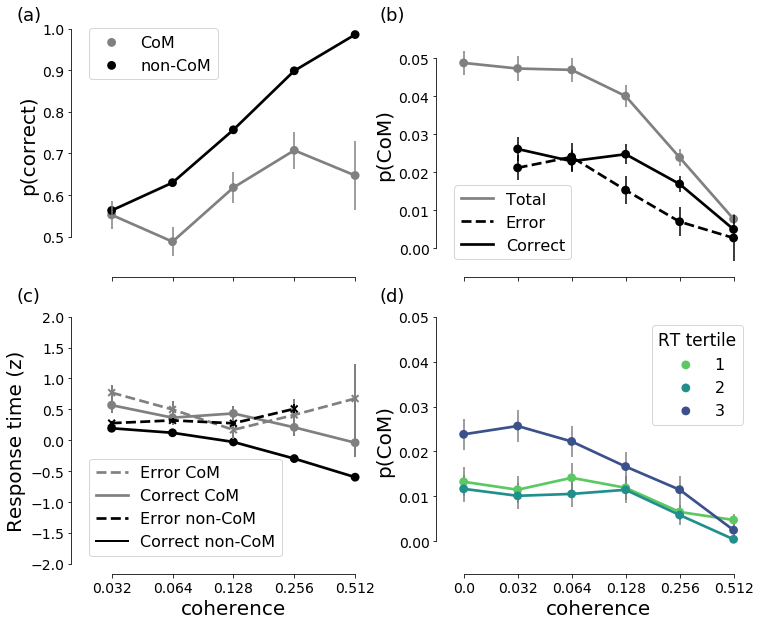

In [251]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex='col', sharey=False)

# here we can exclude 
# c = choices[(~choices.is_com) | 
#             ((choices.is_com) & (choices.com_type=='late'))]
# print(len(c)/len(choices))

plot_psychometric_function(ax1, choices)
plot_p_com(ax2, choices)
plot_rt(ax3, choices)
plot_p_com_vs_rt(ax4, choices)

fig.text(0.05, 0.88, '(a)', fontsize=18)
fig.text(0.47, 0.88, '(b)', fontsize=18)
fig.text(0.05, 0.49, '(c)', fontsize=18)
fig.text(0.47, 0.49, '(d)', fontsize=18)

sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'exp_results.png') , bbox_inches='tight')

# Figure 3

In [249]:
def ms_to_s(traj):
    traj.timestamp = np.linspace(0,4000,4000)
    traj.timestamp = (traj.timestamp - traj.timestamp.min())/1000.0
    return traj

def resample_trajectory(traj, n_steps):
    # Make the sampling time intervals regular
    n = np.arange(0, n_steps + 1)
    t_regular = np.linspace(traj.timestamp.min(), traj.timestamp.max(), n_steps + 1)
    mouse_x_interp = np.interp(t_regular, traj.timestamp.values, traj.mouse_x.values)
    traj_interp = pd.DataFrame([n, t_regular, mouse_x_interp]).transpose()
    traj_interp.columns = ['n', 'timestamp', 'mouse_x']

    return traj_interp

def plot_traj_x_with_model(ax, exp_traj, model_traj):   
    ax.plot(exp_traj.timestamp[::4], exp_traj.mouse_x[::4], marker='o', markersize=7,
            alpha=0.6, label='Experiment', color='grey', lw=5)
    
    model_traj = resample_trajectory(ms_to_s(model_traj), n_steps=100)
    
    stop_point= model_traj.tail(1).index[0];
    ax.plot(model_traj.timestamp, model_traj.mouse_x, lw=5, markersize=7,
            alpha=0.6, label='Model', color='C0')
    
    plot_response_areas(exp_traj, ax)
    ax.set_ylim((-1100, 1100))
    ax.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5), frameon=False, fontsize=20)
    ax.tick_params(axis='both', labelsize=18)
    
def plot_trajectories_x(exp_non_com_traj, exp_com_traj, model_non_com_x_traj, model_com_x_traj):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey='row')

    plot_traj_x_with_model(ax1, exp_non_com_traj, model_non_com_x_traj)
    plot_traj_x_with_model(ax2, exp_com_traj, model_com_x_traj)

    label_font_size = 24

    ax1.set_title('non-CoM')
    ax2.set_title('CoM')

    ax1.set_xlim([0, exp_non_com_traj.timestamp.max()])
    ax1.set_xlabel('time (s)', fontsize=label_font_size)
    ax1.set_ylabel('x position (px)', fontsize=label_font_size)

    ax2.set_xlim([0, exp_com_traj.timestamp.max()])
    ax2.set_xlabel('time (s)', fontsize=label_font_size)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

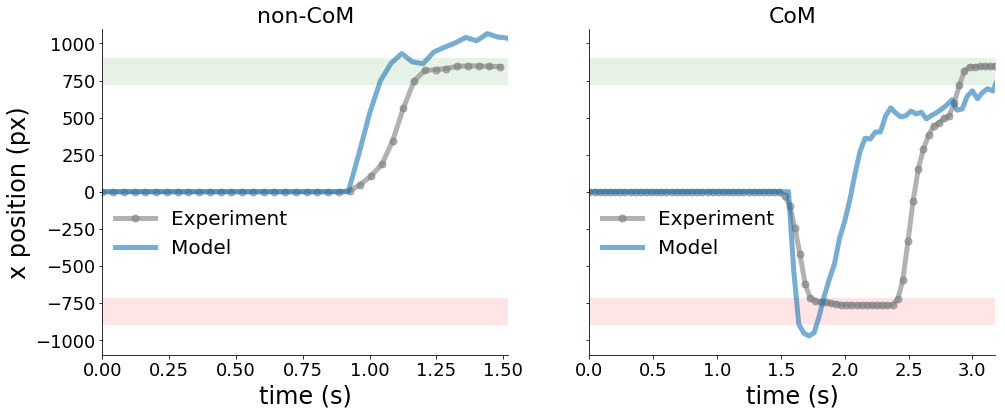

In [28]:
model_non_com_x_traj = pd.read_csv(os.path.join(model_output_csv_path, 'x_traj_non_com.txt'), sep=',')
model_com_x_traj = pd.read_csv(os.path.join(model_output_csv_path, 'x_traj_com.txt'), sep=',')
plot_trajectories_x(exp_non_com_traj=dynamics.loc[(391, 2, 10, 39)], exp_com_traj=dynamics.loc[(391, 3, 6, 17)],
                    model_non_com_x_traj=model_non_com_x_traj, model_com_x_traj=model_com_x_traj)
plt.savefig(os.path.join(figure_path, 'trajectories_x.png') , bbox_inches='tight')

# Figure 4